In [1]:
from __future__ import print_function, division, absolute_import

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=20"

import jax.numpy as np
from numpy.random import choice
import numpy as onp
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev, hessian, pmap
from jax import random
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers
from jax.tree_util import tree_map
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools
from matplotlib import animation
from IPython.display import HTML
from IPython.display import display, Image
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import json

from collections import OrderedDict

import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

import matplotlib.gridspec as gridspec

from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
from scipy import integrate

from jax.nn import swish, tanh

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

left  = 0.05    # the left side of the subplots of the figure
right = 0.925   # the right side of the subplots of the figure
bottom = 0.15   # the bottom of the subplots of the figure
top = 0.85      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.25   # the amount of height reserved for white space between subplots

## Data preprocessing

In [3]:
n_moments = 1
moment_dict = {}

experimental_file = '../../' + 'data' + '/TAP_experimental_data.json'
with open(experimental_file, 'r') as f:
    experimental_data = json.load(f)
experimental_data = json.loads(experimental_data, object_pairs_hook=OrderedDict)['1']

# Calculate and save the 0th moment of each gas species at each pulse
for j, k in enumerate(experimental_data):
    if k == 'time':
        continue
    else:
        moment_dict[k] = {}
        for i in experimental_data[k].keys():
            moment_dict[k][i] = {}
            sub_times = np.array(experimental_data['time'][i])

            for n in range(n_moments):
                moment_dict[k][i]['M' + str(n)] = float(jax.scipy.integrate.trapezoid(np.array(experimental_data[k][i]) * sub_times**n, sub_times))


In [4]:
moments_data = moment_dict

# Pulse use to train and test the interpolation
pulse_train = [0, 1, 2, 5, 8]
pulse_test = [3, 4, 6, 7, 9]

pulse_train = [str(p) for p in pulse_train]
pulse_test = [str(p) for p in pulse_test]

n_pulse = 0
n_gas = 0

moments_train = []
moments_test = []
for j, k in enumerate(moments_data):
    if k == 'Ar':
        continue
    else:
        for i in moments_data[k].keys():
            if i in pulse_train:
                moments_train.append(np.array(moments_data[k][i]['M0']))
            elif i in pulse_test:
                moments_test.append(np.array(moments_data[k][i]['M0']))
            else:
                print('pulse not specified', i)
n_pulse = int(i) + 1
n_gas = j

moments_train = np.array(moments_train).reshape(-1, len(pulse_train)).T
moments_test = np.array(moments_test).reshape(-1, len(pulse_test)).T

# row--pulse,   column--species

In [5]:
# read concentration
f = open('../../data/TAP_thin_data.json')
thin_data = json.load(f)
f.close()
thin_data = json.loads(thin_data)['1']

n_species = 0

y_train = []
y_test = []

t_train = []
t_test = []

# Subsampling and organizing the NN input format
for j, k in enumerate(thin_data):
    if k == 'time':
        for i in thin_data[k].keys():
            t_temp = thin_data[k][i][14:40:1]
            t_temp += thin_data[k][i][40:100:3]
            t_temp += thin_data[k][i][100:300:5]
            t_temp += thin_data[k][i][300::30]
            if i in pulse_train:
                t_train.extend(np.array(t_temp))
            elif i in pulse_test:
                t_test.extend(np.array(t_temp))
                
        t_train = np.log(np.array([t_train]).T)
        t_test = np.log(np.array([t_test]).T)
        
        moment_t = []
        for n in range(len(pulse_train)):
            moment_t.extend(np.broadcast_to(moments_train[n], (len(t_temp), len(moments_train[n]))))
        t_input = np.concatenate((t_train, np.array(moment_t)), axis = 1)
        
        moment_t = []
        for n in range(len(pulse_test)):
            moment_t.extend(np.broadcast_to(moments_test[n], (len(t_temp), len(moments_test[n]))))
        t_input_test = np.concatenate((t_test, np.array(moment_t)), axis = 1)
            
    elif k == 'Ar':
        continue
    
    else:
        y_temp_train = []
        y_temp_test = []
        for i in thin_data[k].keys():
            y_temp_i = []
            if i in pulse_train:
                y_temp_i = thin_data[k][i][14:40:1] + thin_data[k][i][40:100:3] + thin_data[k][i][100:300:5] + thin_data[k][i][300::30]
                y_temp_train += list(y_temp_i)

            if i in pulse_test:
                y_temp_i = thin_data[k][i][14:40:1] + thin_data[k][i][40:100:3] + thin_data[k][i][100:300:5] + thin_data[k][i][300::30]
                y_temp_test += list(y_temp_i)
                
        y_train.append(np.array(y_temp_train))
        y_test.append(np.array(y_temp_test))


n_species = int(j) - 1
total_species = n_species

# Scale to range 0 to 1
y_train = onp.array(y_train)
y_train_scale = np.max(y_train, axis = 1)

y_test = onp.array(y_test)
y_test_scale = np.max(y_train, axis = 1)

conc_inv = (y_train.T/y_train_scale, t_input)
conc_inv_test = (y_test.T/y_test_scale, t_input_test)

In [13]:
n_latent = 3

def read_flux(file_name, p_train, p_test):
    
    f_path = file_name
    f = open(f_path)
    flux_data = json.load(f)
    f.close()
    flux_data = json.loads(flux_data)['1']
    
    y_train = []
    y_test = []
    for j, k in enumerate(flux_data):
        if k == 'time':
            continue
        elif k == 'Ar':
            continue
        else:
            y_temp_train = []
            y_temp_test = []
            for i in flux_data[k].keys():
                if i in p_train:
                    y_temp_train += flux_data[k][i][14:40:1]
                    y_temp_train += flux_data[k][i][40:100:3]
                    y_temp_train += flux_data[k][i][100:300:5]
                    y_temp_train += flux_data[k][i][300::30]
                if i in p_test:
                    y_temp_test += flux_data[k][i][14:40:1]
                    y_temp_test += flux_data[k][i][40:100:3]
                    y_temp_test += flux_data[k][i][100:300:5]
                    y_temp_test += flux_data[k][i][300::30]
            y_train.append(np.array(y_temp_train))
            y_test.append(np.array(y_temp_test))
            
    for i in range(n_latent):
        y_train.append(np.zeros((len(t_input))))
        y_test.append(np.zeros((len(t_input_test))))
    
    y_train = np.array(y_train).T
    y_test = np.array(y_test).T
        
    return y_train, y_test

flux_in_train, flux_in_test = read_flux('../../data/TAP_cat_in.json', pulse_train, pulse_test)
flux_out_train, flux_out_test = read_flux('../../data/TAP_cat_out.json', pulse_train, pulse_test)

L_thin = 0.17364

net_flux_train = ((flux_in_train - flux_out_train)/L_thin)
net_flux_test = ((flux_in_test - flux_out_test)/L_thin)

# Data feed into KINN
data_inv = (np.concatenate((conc_inv[0], net_flux_train), axis = -1), conc_inv[-1])
data_inv_test = (np.concatenate((conc_inv_test[0], net_flux_test), axis = -1), conc_inv_test[-1])

In [15]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    return (scale * random.normal(key, (m,)))

def init_network_params(sizes, key, scale):
    '''
    Initialize all layers for a fully-connected neural network with sizes "sizes"
    '''
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def init_model_params(size, key, scale):
    '''
    Initialize kinetic model with size "size"
    '''
    key = random.split(key,2)[-1] 
    return [random_model_params(s, key, scale) for s in size]

@jit
def act_fun(x):
    return swish(x)
    
@jit
def state(params, t):
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = act_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    # Absolute function at output layer to guarantee nonnegative concentration
    y= np.abs(y)
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))

@jit
def diff_state(params,t):
    '''
    Backpropogation through jacobian
    '''
    i = np.arange(len(t))
    return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])
    
def loss(get_errors, params, batch, flux):
    return np.array([_.sum() for _ in get_errors(params,batch, flux)]).sum()

def train(params,data,ferrors,loss,num_epochs,num_iter,opt_objs,err_tags,batch_size=None):
    opt_state, opt_update, get_params, iter_data = opt_objs
    
    @jit
    def step(data, params):
        batch = [_[:,:total_species] for _ in data]
        flux = data[0][:, total_species:]    
        grads = grad(lambda ferrors, params, batch, flux :np.nan_to_num(loss(ferrors, params, batch, flux))\
                     ,argnums=1)(ferrors, params, batch, flux)
        return grads
    
    # Parallelized training
    step_parallel = pmap(step, in_axes = (0, None))
    
    def mean_map(grad):
        return tree_map(lambda x: x.mean(axis = 0), grad)
    mean_fn = jit(mean_map)
    
    @jit
    def update(itercount, grads, opt_state):
        return opt_update(itercount, grads, opt_state)
    
    itercount = itertools.count()        
    if not batch_size:
        batch_size = data[0].shape[0]
    
    # Use 20 processors, change with number of processor used
    # Reshape the data for distribution over processors
    data_parallel = (data[0].reshape(20,-1,total_species*2), data_inv[1].reshape(20,-1,1+n_gas))
    
    iter_data += [get_params(opt_state).copy()]
    for j in range(num_epochs):
        clear_output(wait=True)
        random_data = data  # No shuffle, random if shuffle
        
        for i in range(int(num_iter)):
            params = get_params(opt_state)
            
            grads_parallel = step_parallel(data_parallel, params)
            grads = mean_fn(grads_parallel)
            
            opt_state = update(next(itercount), grads, opt_state)
    
        batch = [_[:,:total_species] for _ in data]
        flux = data[0][:, total_species:]
    
        params = get_params(opt_state) 
        loss_it_batch = loss(ferrors, params, batch, flux)

        errs = [_.sum() for _ in ferrors(params,batch, flux)]

        print('Epoch: {:4d}, Loss Batch: {:.5e}'.format(j, loss_it_batch)+\
                  ''.join([', Fit {}: {:.5e}'.format(_,__) for _,__ in zip(err_tags,errs)]))
        print(params[-1])
        iter_data += [params.copy()]
    
    return params, [opt_state, opt_update, get_params, iter_data]

In [16]:
@jit
def model(batch, model_params, flux):
    '''
    Define the ODE kinetic model
    '''
    x, t = batch
    k,  = model_params
    
    # Ensure positive kinetic parameter values
    k, x = [np.abs(_) for _ in [k,x]]
    
    # Scale concentration back to ensure kinetic parameters are in the original scale
    x = x * y_train_scale
    
    return np.array(np.array([[-k[0]*x[0]*x[5] + k[1]*x[3] - k[5]*x[0]*x[4]],
                    [-k[2]*x[1]*x[5]**2],
                    [k[3]*x[3]*x[4] - k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]],
                    [k[0]*x[0]*x[5] - k[1]*x[3] - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2],
                    [(k[2]*x[1]*x[5]**2)*2 - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2 - k[5]*x[0]*x[4]],
                    [-k[0]*x[0]*x[5] + k[1]*x[3] - (k[2]*x[1]*x[5]**2)*2 + k[3]*x[3]*x[4]*2 - 2*k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]]]) + 
                    onp.reshape(flux, (6,1)))

batched_model = lambda batch, model_params, flux : vmap(model,in_axes=(0,None,0))(batch,model_params,flux)[:,:,0]#, in_axes=(None, 0)

In [17]:
@jit
def errors_inv(params, batch, flux):
    '''
    Total loss as the combine of data loss and model loss
    '''
    x, t = batch
    NA = np.array(flux)
    nn_params, model_params = params
    pred_x = batched_state(nn_params,t)
    err_data = ((pred_x-x)**2).sum(axis=1)
    
    # Chain rule
    err_model = ((diff_state(nn_params,t) / np.exp(t[:,0:1]) - batched_model([pred_x,t],model_params,NA) / y_train_scale)**2).sum(axis=1)
    
    return [err_data, 1e-3*err_model]

In [19]:
layer_sizes = [1+n_species-n_latent, 10, 10, 6] # inputs, hidden..., output layes
model_size = [6]
key = random.PRNGKey(0)

nn_scale = 0.01 # weights scales
model_scale = 0.00001 # model scale (assume low so as not to eb bias)

nn_params = init_network_params(layer_sizes, key, nn_scale)
model_params = init_model_params(model_size, key, model_scale)
params = [nn_params, model_params] #pack

opt_inv = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
opt_inv = (opt_inv[0](params), opt_inv[1], opt_inv[2], [])
initial_cond = [0., 0., 0., 0., 0., 30.]

In [24]:
%%time
err_tags = ['Data','Model']
num_epochs = 1000
num_iter = 10
batch_size = None


for i in range(10):
    params = train(params,data_inv,errors_inv,loss,num_epochs,num_iter,opt_inv,err_tags,batch_size=None)
    [params, opt_inv] = params
    nn_params_inv, model_params_inv = params
    nn_params = nn_params_inv
    model_params = model_params_inv

Epoch:    0, Loss Batch: 6.58396e+00, Fit Data: 4.85534e-01, Fit Model: 6.09843e+00
[Array([-11.47279906,  -0.51867702,  -0.2514891 ,   0.31309989,
         0.01703778,  12.11122715], dtype=float64)]
CPU times: user 2.33 s, sys: 199 ms, total: 2.53 s
Wall time: 1.53 s


In [ ]:
np.savez('./results/multi_ideal', data = {'nn_params' :nn_params_inv, 'model_params': model_params_inv})

## Visualize result

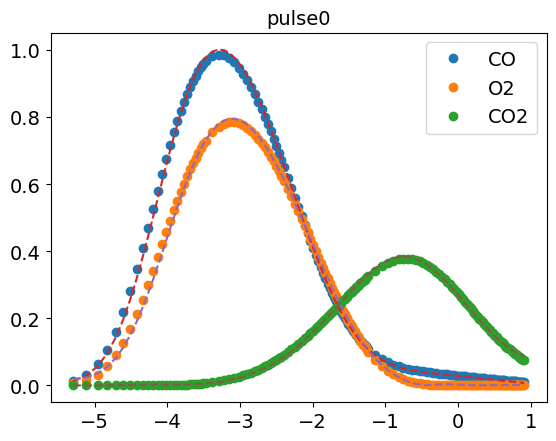

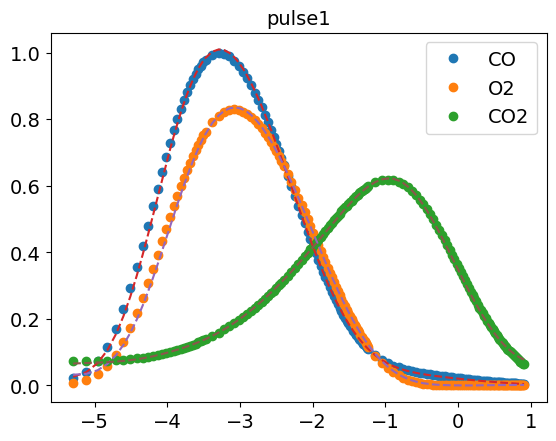

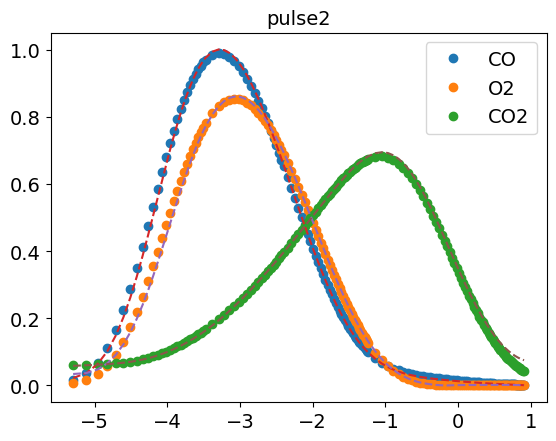

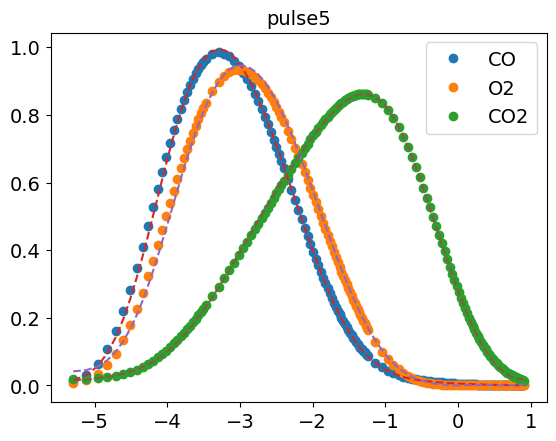

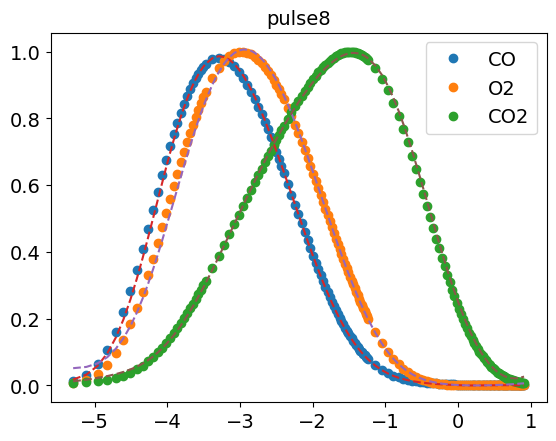

In [123]:
for n in range(len(pulse_train)):
    plt.figure()
    plt.plot(conc_inv[1][n_p*n:n_p*(n+1),0], conc_inv[0][n_p*n:n_p*(n+1),0:3], 'o')
    plt.legend(['CO', 'O2', 'CO2'])
    plt.title('pulse' + str(pulse_train[n]))
    lines2a = plt.plot(t_train[n_p*n:n_p*(n+1)],batched_state(nn_params_inv, t_input)[n_p*n:n_p*(n+1),0:3],'--',\
                      ms=6,markerfacecolor='None',markeredgecolor='black')

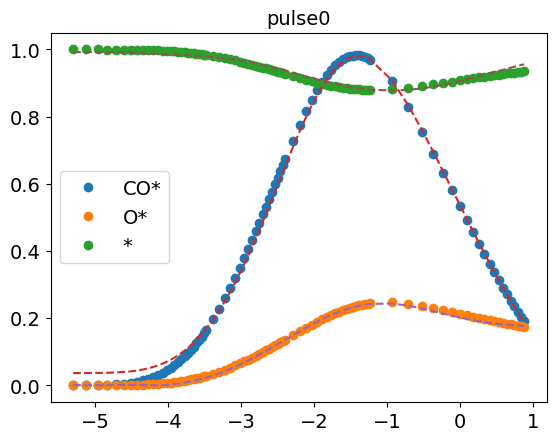

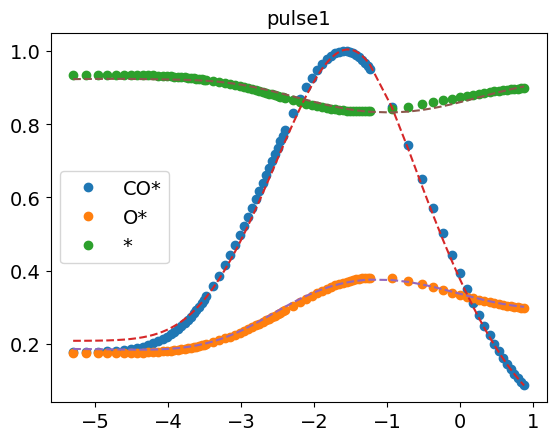

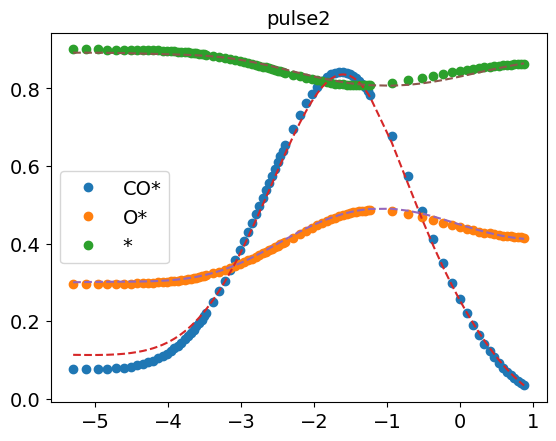

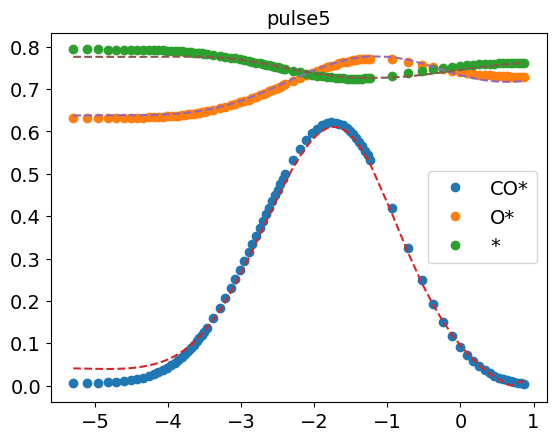

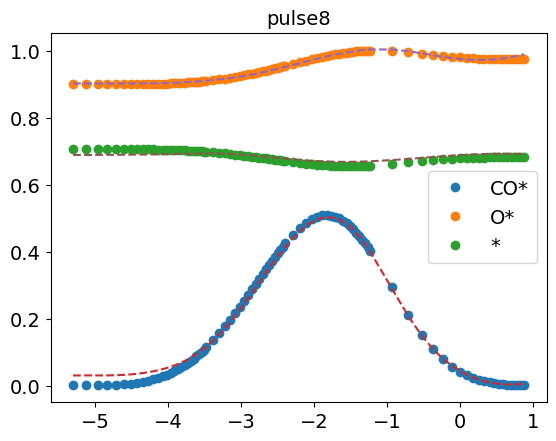

In [108]:
for n in range(len(pulse_train)):
    plt.figure()
    plt.plot(conc_inv[1][n_p*n:n_p*(n+1),0], conc_inv[0][n_p*n:n_p*(n+1),3:], 'o')
    plt.legend(['CO*', 'O*','*'])
    plt.title('pulse' + str(pulse_train[n]))
    lines2a = plt.plot(t_train[n_p*n:n_p*(n+1)],batched_state(nn_params_inv, t_input)[n_p*n:n_p*(n+1),3:],'--',\
                      ms=6,markerfacecolor='None',markeredgecolor='black')

/var/tmp/pbs.1678107.sawtoothpbs/ipykernel_69270/1407020531.py:29: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = fig.legend(['_nolegend_', '_nolegend_', '_nolegend_', '$CO$', '$O_2$', '$CO_2$'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)


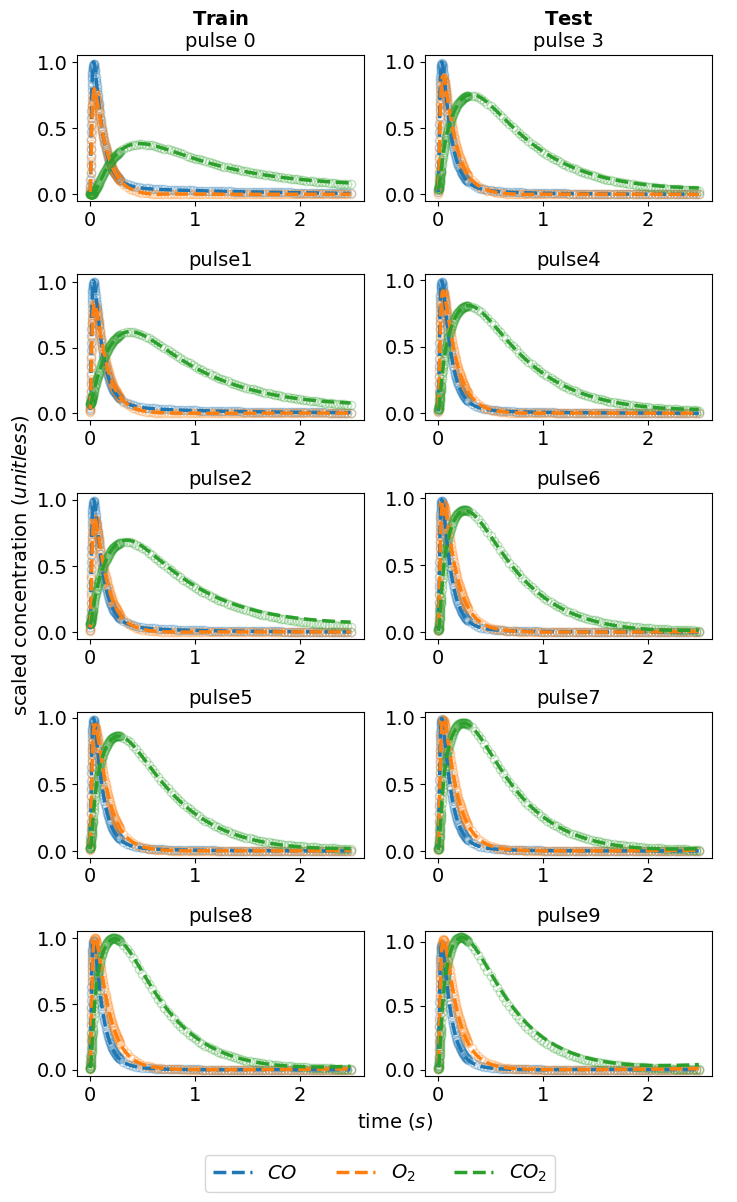

In [40]:
fig, axs = plt.subplots(5,2, figsize=(8, 12), tight_layout = True)

fig.add_subplot(111, frameon=False)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('time $(s)$')
plt.ylabel('scaled concentration $(unitless)$')

# Fit
for n in range(len(pulse_train)):
    axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]), (y_train.T/y_train_scale)[n_p*n:n_p*(n+1),:n_gas],'o',
                  alpha = 0.3, ms = 6, markerfacecolor = "None")
    axs[n, 0].set_prop_cycle(None)
    axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]),batched_state(nn_params, t_input)[n_p*n:n_p*(n+1),:n_gas],'--',\
                      linewidth = 2.5)
    axs[n, 0].set_title('pulse' + str(int(pulse_train[n])))
axs[0,0].set_title(r'$\bf{Train}$' + '\n'+'pulse ' + str(pulse_train[0]))

# Interpolate
for n in range(len(pulse_test)):
    axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]), (y_test.T/y_test_scale)[n_p*n:n_p*(n+1),:n_gas], 'o',
                  alpha = 0.3, ms = 6, markerfacecolor = "None")
    axs[n, 1].set_prop_cycle(None)
    axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]),batched_state(nn_params, t_input_test)[n_p*n:n_p*(n+1),:n_gas],'--',\
                      linewidth = 2.5)
    axs[n, 1].set_title('pulse' + str(int(pulse_test[n])))
axs[0,1].set_title(r'$\bf{Test}$' + '\n'+'pulse ' + str(pulse_test[0]))

leg = fig.legend(['_nolegend_', '_nolegend_', '_nolegend_', '$CO$', '$O_2$', '$CO_2$'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)

/var/tmp/pbs.1678107.sawtoothpbs/ipykernel_69270/1245190481.py:33: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = fig.legend(['_nolegend_', 'CO*', '_nolegend_', 'O*', '_nolegend_', '*'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)


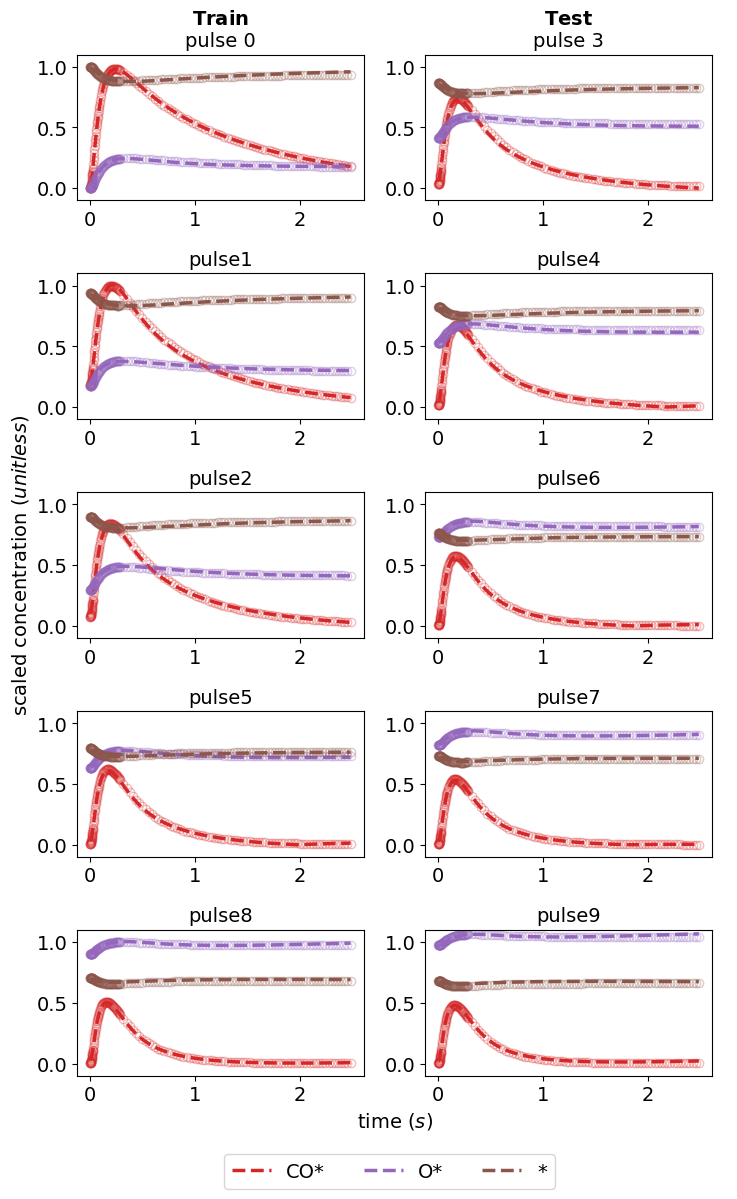

In [41]:
fig, axs = plt.subplots(5,2, figsize=(8, 12), tight_layout = True)

fig.add_subplot(111, frameon=False)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('time $(s)$')
plt.ylabel('scaled concentration $(unitless)$')

for n in range(len(pulse_train)):
    for i in range(n_gas,n_species):
        axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]), (y_train.T/y_train_scale)[n_p*n:n_p*(n+1),i],'o',
                  color = 'C{}'.format(i), alpha = 0.3, ms = 6, markerfacecolor = "None")
        axs[n, 0].set_prop_cycle(None)
        axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]),batched_state(nn_params, t_input)[n_p*n:n_p*(n+1),i],'--',\
                      color = 'C{}'.format(i), linewidth = 2.5)
        
        axs[n, 0].set_title('pulse' + str(int(pulse_train[n])))
        axs[n, 0].set(ylim = (-0.1, 1.1))
axs[0,0].set_title(r'$\bf{Train}$' + '\n'+'pulse ' + str(pulse_train[0]))

for n in range(len(pulse_test)):
    for i in range(n_gas,n_species):
        axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]), (y_test.T/y_test_scale)[n_p*n:n_p*(n+1),i], 'o',
                  color = 'C{}'.format(i), alpha = 0.3, ms = 6, markerfacecolor = "None")
        axs[n, 1].set_prop_cycle(None)
        axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]),batched_state(nn_params, t_input_test)[n_p*n:n_p*(n+1),i],'--',\
                      color = 'C{}'.format(i), linewidth = 2.5)
        axs[n, 1].set_title('pulse' + str(int(pulse_test[n])))
        axs[n, 1].set(ylim = (-0.1, 1.1))
axs[0,1].set_title(r'$\bf{Test}$' + '\n'+'pulse ' + str(pulse_test[0]))

leg = fig.legend(['_nolegend_', 'CO*', '_nolegend_', 'O*', '_nolegend_', '*'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)

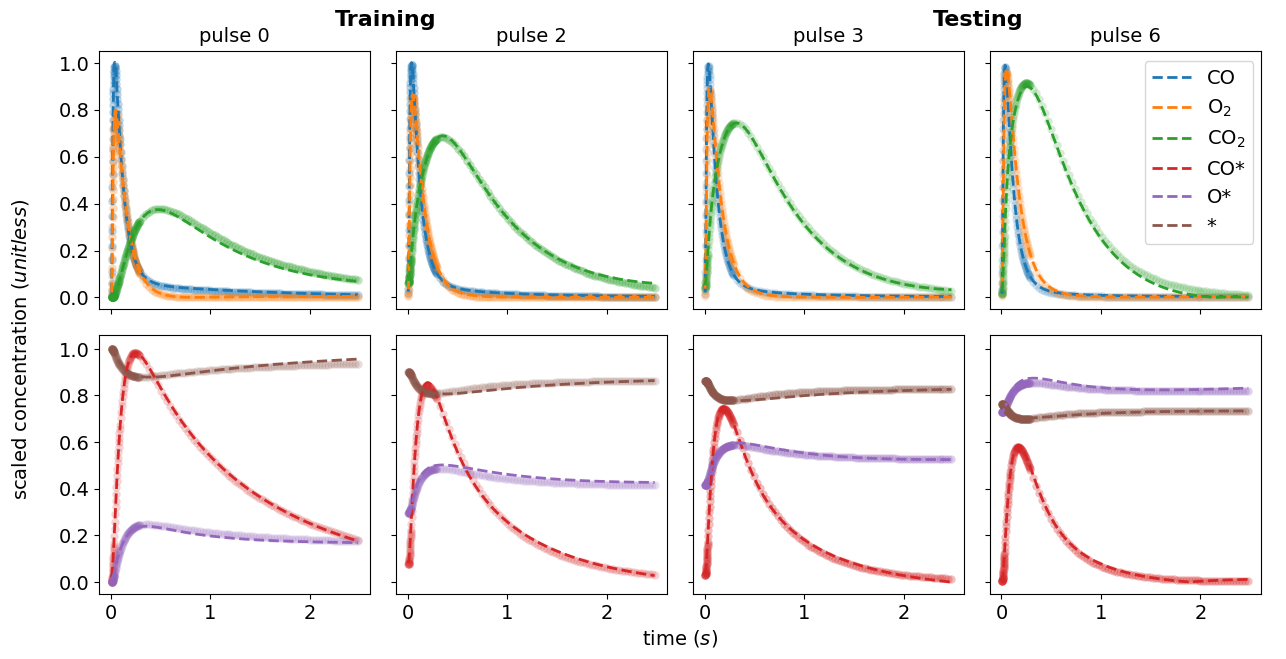

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(13, 7), sharey = 'row', sharex = 'col', tight_layout = True)

fig.add_subplot(111, frameon=False)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'time $(s)$')

# Only show 2 pulse here for space using
sub_pulse_train = [0, 2]
for n in range(len(sub_pulse_train)):
    m = sub_pulse_train[n]
    for i in range(n_gas):
        axs[0,n].plot(np.exp(t_train[n_p*m:n_p*(m+1)]), y_train.T[n_p*m:n_p*(m+1),i]/y_train_scale[i]
                    ,'o',color = 'C{}'.format(i), markeredgecolor='none', ms = 6, alpha = 0.3)
    plt.gca().set_prop_cycle(None)
    for i in range(n_gas):
        axs[0,n].plot(np.exp(t_train[n_p*m:n_p*(m+1)]),batched_state(nn_params_inv, t_input)[n_p*m:n_p*(m+1),i]
                      ,'--',color = 'C{}'.format(i),linewidth=2, label = ['CO','O2','CO2'])
    plt.setp(axs[0, n].get_xticklabels(), visible=False)
    axs[0,n].set_title('pulse ' + pulse_train[m])
    

sub_pulse_test = [0, 2]
for n in range(len(sub_pulse_test)):
    m = sub_pulse_test[n]
    for i in range(n_gas):
        axs[0,n+2].plot(np.exp(t_test[n_p*m:n_p*(m+1)]), y_test.T[n_p*m:n_p*(m+1),i]/y_test_scale[i]
                            ,'o',color = 'C{}'.format(i), markeredgecolor='none', ms = 6, alpha = 0.2)
    plt.gca().set_prop_cycle(None)
    for i in range(n_gas):
        axs[0,n+2].plot(np.exp(t_test[n_p*m:n_p*(m+1)]),batched_state(nn_params_inv, t_input_test)[n_p*m:n_p*(m+1),i]
                      ,'--',color = 'C{}'.format(i),linewidth=2)
    plt.setp(axs[0, n+2].get_xticklabels(), visible=False)
    axs[0,n+2].set_title('pulse ' + pulse_test[m])

    
for n in range(len(sub_pulse_train)):
    m = sub_pulse_train[n]
    for i in range(n_gas,n_species):
        axs[1,n].plot(np.exp(t_train[n_p*m:n_p*(m+1)]), y_train.T[n_p*m:n_p*(m+1),i]/y_train_scale[i]
                                ,'o',color = 'C{}'.format(i), markeredgecolor='none', ms = 6, alpha = 0.2)
    plt.gca().set_prop_cycle(None)
    for i in range(n_gas,n_species):
        axs[1,n].plot(np.exp(t_train[n_p*m:n_p*(m+1)]),batched_state(nn_params_inv, t_input)[n_p*m:n_p*(m+1),i]
                      ,'--',color = 'C{}'.format(i),linewidth=2, label = ['CO*', 'O*'])
        
for n in range(len(sub_pulse_test)):
    m = sub_pulse_test[n]
    for i in range(n_gas,n_species):
        axs[1,n+2].plot(np.exp(t_test[n_p*m:n_p*(m+1)]), y_test.T[n_p*m:n_p*(m+1),i]/y_test_scale[i]
                                                       ,'o',color = 'C{}'.format(i), markeredgecolor='none', ms = 6, alpha = 0.3)
    plt.gca().set_prop_cycle(None)
    for i in range(n_gas,n_species):
        axs[1,n+2].plot(np.exp(t_test[n_p*m:n_p*(m+1)]),batched_state(nn_params_inv, t_input_test)[n_p*m:n_p*(m+1),i]
                      ,'--',color = 'C{}'.format(i), linewidth=2)

        
fig.text(0.01, 0.5, r'scaled concentration $(unitless)$', va='center', rotation='vertical')
fig.text(0.26, 0.97, r'Training', va='center', fontsize = 16, fontweight = 'bold')
fig.text(0.72, 0.97, r'Testing', va='center', fontsize = 16, fontweight = 'bold')

handles_gas, _ = axs[0,1].get_legend_handles_labels()
handles_surface, _ = axs[1,1].get_legend_handles_labels()
handles = handles_gas + handles_surface

labels = ['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*', '*']
fig.legend(handles, labels, loc=[0.89, 0.63])

fig.tight_layout()

/var/tmp/pbs.1678107.sawtoothpbs/ipykernel_69270/338649743.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


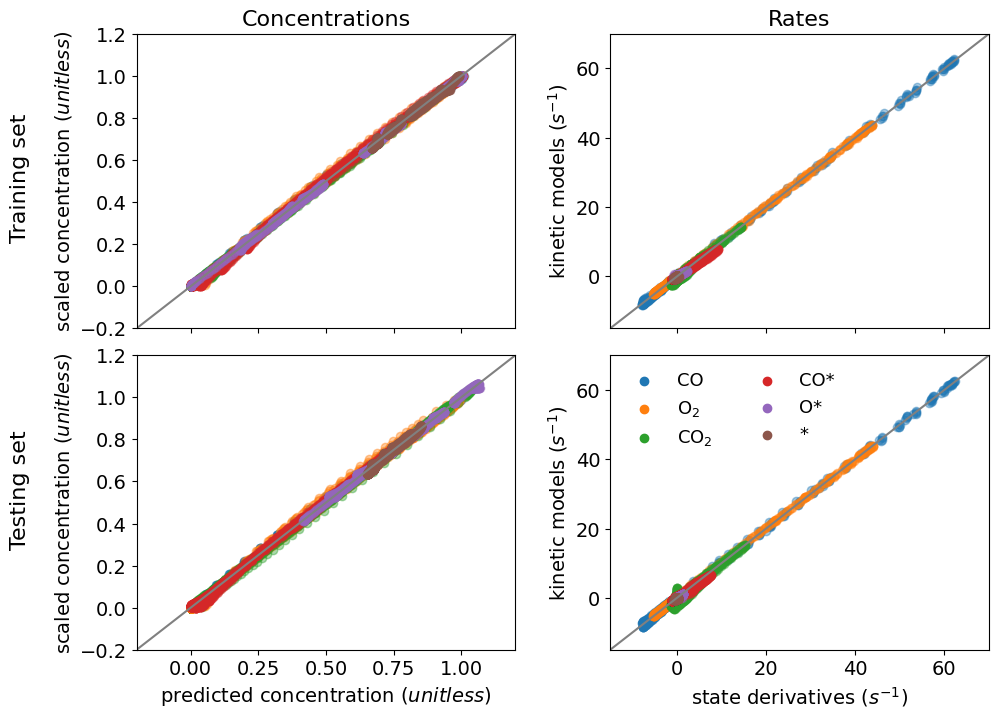

In [22]:
fig = plt.figure(figsize = (11,8))

gs = gridspec.GridSpec(4, 2, figure = fig)
gs.update(wspace=0.25)

ax1 = fig.add_subplot(gs[:2, 0])
for i in range(n_species):
    ax1.scatter(batched_state(nn_params, t_input)[:,i], y_train.T[:,i]/y_train_scale[i], 
                color = 'C{}'.format(i), alpha = 0.4)
ax1.set(xlim=(-0.2, 1.2), ylim=(-0.2, 1.2))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="-", c = '.5')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_title('Concentrations', fontsize = 16)
ax1.set_ylabel('scaled concentration $(unitless)$')

ax2 = fig.add_subplot(gs[2:, 0], sharex = ax1)
for i in range(n_species):
    ax2.scatter(batched_state(nn_params, t_input_test)[:,i], y_test.T[:,i]/y_test_scale[i], 
                color = 'C{}'.format(i), alpha = 0.4)
ax2.set(xlim=(-0.2, 1.2), ylim=(-0.2, 1.2))
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="-", c = '.5')
ax2.set_xlabel('predicted concentration $(unitless)$')
ax2.set_ylabel('scaled concentration $(unitless)$')

ax3 = fig.add_subplot(gs[:2, 1])
for i in range(n_species):
    ax3.scatter((diff_state(nn_params,t_input) / np.exp(t_input[:,0:1]))[:,i],
            batched_model([batched_state(nn_params,t_input),t_input], model_params, net_flux_train)[:,i] / y_train_scale[i],
               color = 'C{}'.format(i), alpha = 0.4)
ax3.set(xlim=(-15, 70), ylim=(-15, 70))
ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="-", c = '.5')
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_title('Rates', fontsize = 16)
ax3.set_ylabel('kinetic models $(s^{-1})$')

ax4 = fig.add_subplot(gs[2:, 1], sharex = ax3)
for i in range(n_species):
    ax4.scatter((diff_state(nn_params,t_input_test)/ np.exp(t_input_test[:,0:1]))[:,i],
        batched_model([batched_state(nn_params,t_input_test),t_input_test], model_params, net_flux_test)[:,i] /y_test_scale[i],
               color = 'C{}'.format(i), alpha = 0.4)
ax4.set(xlim=(-15, 70), ylim=(-15, 70))
ax4.plot(ax4.get_xlim(), ax4.get_ylim(), ls="-", c = '.5')
leg = ax4.legend(['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*','*'], ncol = 2,  prop={'size': 13}, frameon = False)
ax4.set_xlabel('state derivatives $(s^{-1})$')
ax4.set_ylabel('kinetic models $(s^{-1})$')

fig.text(0.01, 0.7, 'Training set', va='center', fontsize = 16, rotation='vertical')
fig.text(0.01, 0.31, 'Testing set', va='center', fontsize = 16, rotation='vertical')

for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [30]:
def error_wrt_params(p):
    alpha_factor = np.array([[1], [1e-3]])
    return (np.array(errors_inv([nn_params, p], conc_inv, net_flux_train))/alpha_factor).mean()
hessian_func = jit(hessian(error_wrt_params))

# calculate the Hessian matrix
hessian_matrix = hessian_func(model_params)

# # Inverting the Hessian gives us the covariance matrix
covariance_matrix = np.linalg.inv(np.array(hessian_matrix))[0][0]

# # The standard deviations are the square roots of the diagonal elements of the covariance matrix
standard_deviations = np.sqrt(np.diag(covariance_matrix))

standard_deviations

Array([0.11972036, 0.05971361, 0.00385004, 0.04061693, 0.01902021,
       0.37218517], dtype=float64)

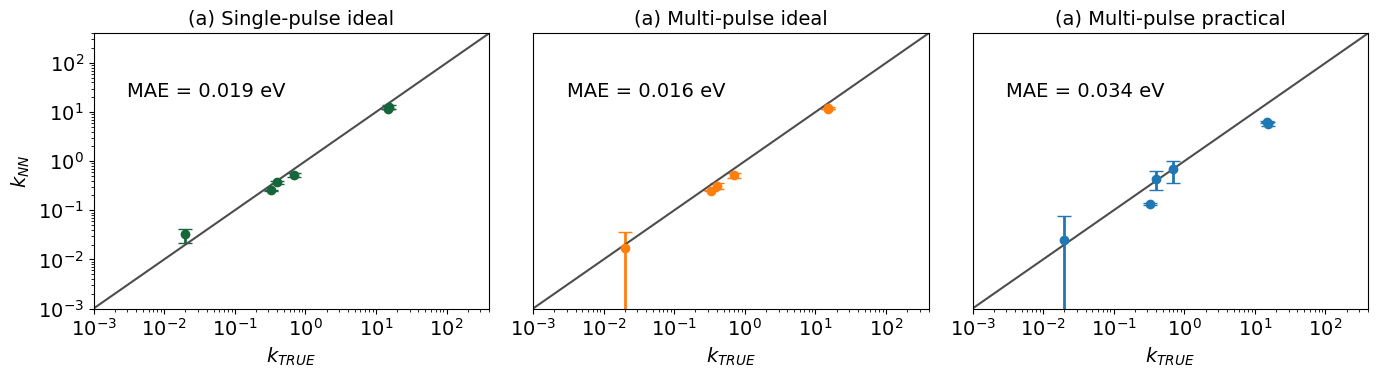

In [33]:
model_params_true = np.array([15, 0.7, 0.33, 0.4, 0.02, 15.2])
model_params_fit = np.abs(model_params_inv[0])

model_params_single = np.abs(np.array([-11.52271015,  -0.52831707,  -0.25274057,   0.36894424,
         -0.03216084,  12.76715619]))
model_params_std_single = np.array([0.08979346, 0.04729043, 0.00265937, 0.03026766, 0.01036388, 1.21843087])

model_params_uptake = np.abs(np.array([-6.35536503,  0.6937773 , -0.13582364,  0.43858398,  0.02428112, 5.7058429 ]))
model_params_std_uptake = np.array([0.24181838, 0.33424296, 0.00813729, 0.18298266, 0.05358233, 0.52107784])


fig, axs = plt.subplots(1,3, figsize=(14, 4), tight_layout = True)

axs[0].errorbar(model_params_true, model_params_single, yerr = model_params_std_single, fmt = 'o',
                   color = '#15673b', elinewidth = 2, capsize = 5)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set(xlim=(0.001, 400), ylim=(0.001, 400))
axs[0].plot(axs[0].get_xlim(), axs[0].get_ylim(), ls="-", c = '.3')
axs[0].set_ylabel('$k_{NN}$')
axs[0].set_xlabel('$k_{TRUE}$')
axs[0].set_title('(a) Single-pulse ideal')
axs[0].text(0.003, 20, 'MAE = %.3f eV' % 0.019)

axs[1].errorbar(model_params_true, model_params_fit, yerr = standard_deviations, fmt = 'o',
               color = '#ff7f0e', elinewidth = 2, capsize = 5)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set(xlim=(0.001, 400), ylim=(0.001, 400))
axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), ls="-", c = '.3')
axs[1].yaxis.set_visible(False) 
axs[1].set_xlabel('$k_{TRUE}$')
axs[1].set_title('(a) Multi-pulse ideal')
axs[1].text(0.003, 20, 'MAE = %.3f eV' % 0.016)


axs[2].errorbar(model_params_true, model_params_uptake, yerr = model_params_std_uptake, fmt = 'o',
               elinewidth = 2, capsize = 5)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set(xlim=(0.001, 400), ylim=(0.001, 400))
axs[2].plot(axs[2].get_xlim(), axs[2].get_ylim(), ls="-", c = '.3')
axs[2].yaxis.set_visible(False) 
axs[2].set_xlabel('$k_{TRUE}$')
axs[2].set_title('(a) Multi-pulse practical')
axs[2].text(0.003, 20, 'MAE = %.3f eV' % 0.034)

# All MAE is calculated using the Eyring equation